In [20]:
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np
import csv
import random
import pandas as pd
import scipy.stats as st

In [42]:
#give the file names that we will be analyzing. Need a calibration file and a run file should match
name='250603_system2'
run_file=pd.read_csv('./'+name+'.csv',header=0)
calibration=pd.read_csv('./'+name+'_calibration.csv',header=0)
system='system2'

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


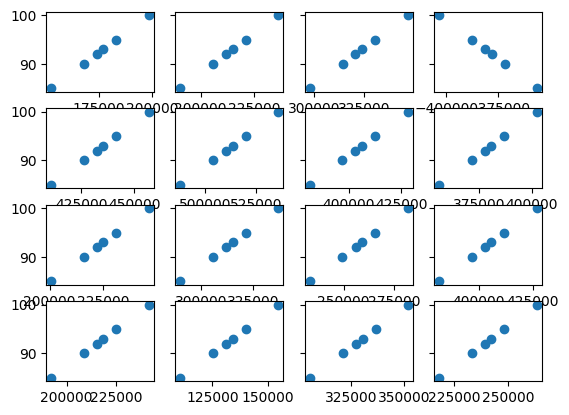

[0.0003252021983927149, 0.0003262189205980769, 0.00030996529619945384, -0.0003192944809454114, 0.0003249847344186305, 0.0003119054815452236, 0.0003207871658700821, 0.00031997010740440827, 0.00032900414359587454, 0.0003165951076739906, 0.00030981985609273687, 0.00033145665347725526, 0.00030187896739394484, 0.00033816022132103675, 0.0003232330390540553, 0.0003291783161004048]


In [43]:
#define the calibration masses (listed as the headers in the calibration csv) and get slopes for each scale
cal_masses=np.array([85,90,92,93,95,100])
scales_slopes=[]
scales_intercept=[]
errors_calibration=[] #list of lists [[error in slope, error in intercept]]
for i in range(0,16):
    if i ==5 and system=='system1':
        scales_slopes+=[0]
        scales_intercept+=[0]
        errors_calibration+=[[0,0]]
    else:
        scale_values=np.array(calibration.iloc[i,1:].values.tolist())
        #print(i)
        output=st.linregress(scale_values,cal_masses)
        scales_slopes+=[output.slope]
        scales_intercept+=[output.intercept]
        errors_calibration+=[[output.stderr,output.intercept_stderr]]

#plot the calibration curves
figure1, ax=plt.subplots(4,4,sharex=False,sharey=True)
for j in range(4):
    for k in range(4):
        i=(j*4)+k
        print(i)
        ax[j,k].scatter(np.array(calibration.iloc[i,1:].values.tolist()),cal_masses)
plt.show()
print(scales_slopes)

In [48]:
def convert_to_mass(file_name,slopes,intercepts):
    cell_=pd.read_csv('./'+file_name+'.csv',header=0)

    mass_data=cell_
    #print(mass_data)
    for i in range(1,17,1):
        #print(mass_data.iloc[:,2*(i-1)+1:2*(i-1)+2])
        #print(mass_data.iloc[:,2*(i-1)+1:2*(i-1)+2]*slopes[i-1])
        mass_data.iloc[:,2*(i-1)+1:2*(i-1)+2]=mass_data.iloc[:,2*(i-1)+1:2*(i-1)+2]*slopes[i-1]+intercepts[i-1]
        #print(mass_data)

    normalization=mass_data.iloc[0,:].to_numpy()
    #print(normalization)
    #get an updated matrix
    update1=mass_data.apply(lambda x: x-normalization, axis=1)
    permeance=[0]*16
    error=[0]*16
    for i in range(1,17,1):
        mass = update1.iloc[100:5000, 2 * (i - 1) + 1:2 * (i - 1) + 2].to_numpy()
        time = update1.iloc[100:5000, 2 * (i - 1):2 * (i - 1) + 1].to_numpy()
        mass=np.reshape(mass,-1)
        time=np.reshape(time,-1)
        output=st.linregress(time, mass)
        # to get permeance in g/(hr*m^2)
        # slope is g/min. Multiply by 60min to get per hour
        # divide by 10cm^2 area. Multiply by 100^2 for cm^2/m^2
        permeance[i-1]=output.slope*60/(10)*(100**2)
        error[i - 1] = output.stderr * 60 / (10) * (100 ** 2)
    # for i in range(13,17,1):
    #     mass = update1.iloc[50:300, 2 * (i - 1) + 1:2 * (i - 1) + 2].to_numpy()
    #     time = update1.iloc[50:300, 2 * (i - 1):2 * (i - 1) + 1].to_numpy()
    #     mass=np.reshape(mass,-1)
    #     time=np.reshape(time,-1)
    #     output=st.linregress(time, mass)
    #     # to get permeance in g/(hr*m^2)
    #     # slope is g/min. Multiply by 60min to get per hour
    #     # divide by 10cm^2 area. Multiply by 100^2 for cm^2/m^2
    #     permeance[i-1]=output.slope*60/(10)*(100**2)
    #     error[i - 1] = output.stderr * 60 / (10) * (100 ** 2)

    return (update1,permeance,error)

In [49]:
output=convert_to_mass(name, scales_slopes,scales_intercept)
print(output[1])
print(output[2])

[-0.39496808457797333, -2.68155465644456, -2.18918571018427, -2.0830812837361043, -24.51778067935221, -25.836525229335486, -25.031796376303873, -25.079209363987843, -25.17992994880377, -25.31715821742179, -25.739861363662836, -25.872299405835307, -26.43469011651239, -25.1096663297409, -25.56718667238028, -24.956731035790018]
[0.0020539929732590854, 0.00882116662629182, 0.015036017048238148, 0.014107429269480085, 0.12107242784342133, 0.10337772882927618, 0.1116243914773801, 0.11186437576100813, 0.09971921112517329, 0.11752935752794433, 0.10065423675117616, 0.08949142131686041, 0.07935748711430576, 0.11620510114774094, 0.12261735419345979, 0.12363252818297234]


In [50]:
def plot_curves(numpyarray,save_name,permeance,error):
    figure1, ax=plt.subplots(4,4,sharex=True,sharey=False)
    for j in range(4):
        for k in range(4):
            i=(j*4)+k
            print(i)
            ax[j,k].scatter(numpyarray.iloc[:,2*i],numpyarray.iloc[:,2*i+1])
            #ax[j,k].set_xlabel("Elapsed Time (minutes)")
            #ax[j,k].set_ylabel("Mass (grams)")
            #ax[j,k].set_ylim(-3,2)
            ax[j,k].set_xlim(0,5000)
            #ax[j,k].text(2000,-0.1,str(permeance[i])[0:6])
            #ax[j,k].text(1000,-0.75,'+/- '+str(error[i])[0:5])
    figure1.supxlabel("Elapsed Time (minutes)")
    figure1.supylabel("Mass (grams)")
    figure1.savefig('./Film_plots/' + save_name+'.png', dpi=300)
    plt.set_cmap('Greens')
    figure1.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_8929/3948357601.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure1.show()


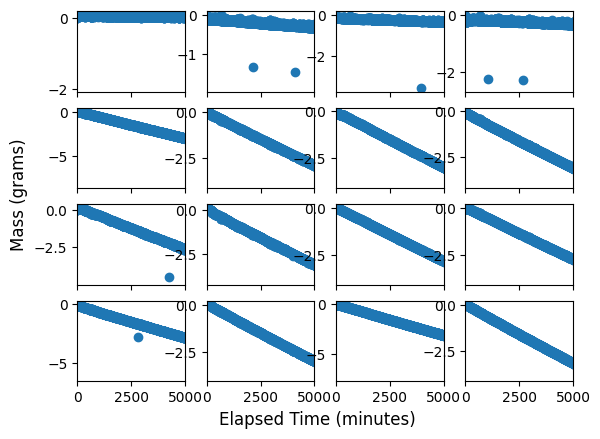

In [51]:
plot_curves(output[0],name,output[1],output[2])

In [ ]:
purples=['#8b73d5','#735aac','#393952']
blues=['#b4e6f6','#83c5d5','#4194a4']
gray='#7b8bb4'
pinks=['#ff94ac','#ff4a5a','#c51020']
plt.rcParams["font.family"] = "Arial"
